In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

## Data import and preprocessing

In [2]:
# data import function:

def import_data(link, name):
    sheet_id = link
    sheet_name = name
    url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    name = pd.read_csv(url)
    return name

# importing dataframes:

visitors = import_data('1QEwlbKoT_jbHk9wtJm4LMbpXnb_bS7JJgtTEEEPV_GY', 'visitors')
orders = import_data('1NZOSs7ToT9m5kdEQYX09VqYN6I_BCeJHuyMeAdk3qzM', 'orders')
hypothesis = import_data('15OhflvldqylfQp1hTc5hNnEg25NgEvypMPoq95iz8ck', 'hypothesis')

Each dataframe will be analyzed below.

The first one will be **'hypothesis'**:

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Add two new traffic channels, which will attra...",3,10,8,6
1,"Launch own delivery service, which will shorte...",2,5,4,10
2,Add product recommendation blocks to the onlin...,8,3,7,3
3,"Change the category structure, which will incr...",8,3,3,8
4,Change the background color of the main page t...,3,1,1,1


In [4]:
hypothesis['Hypothesis'].unique()

array(['Add two new traffic channels, which will attract 30% more users',
       'Launch own delivery service, which will shorten the delivery time of orders',
       "Add product recommendation blocks to the online store's website to increase conversion and average order receipt",
       'Change the category structure, which will increase the conversion rate, because users will find the right product faster',
       'Change the background color of the main page to increase user engagement',
       'Add a customer feedback page about the store, which will increase the number of orders',
       'Show banners with current promotions and sales on the main page to increase conversion',
       'Add a subscription form to all the main pages to collect a customer base for email newsletters',
       'Launch a promotion giving a discount on a product on birthday'],
      dtype=object)

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


The dataframe **'hypothesis'** includes 9 lines containing unique hypotheses to be tested, and 5 columns:
- Hypothesis — a brief description of the hypothesis;
- Reach — user coverage on a 10-point scale;
- Impact — impact on users on a 10-point scale;
- Confidence — confidence in the hypothesis on a 10-point scale;
- Efforts — the cost of resources to test the hypothesis on a 10-point scale. The greater the value of Efforts, the more expensive hypothesis testing is.

Column names contain capital letters. For further convenience, the names will be reduced to lowercase:

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

Next, the dataframe **'orders'**:

In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


The 'orders' dataframe includes 1197 rows and 5 columns:
- TransactionID — order ID;
- visitorID — ID of the user who made the order;
- date — the date when the order was made;
- revenue — order revenue;
- group — the A/B test group that the order fell into.

The 'date' column belongs to the type 'object', although it contains information about dates. Thus, this column needs to be converted to the 'datetime' type:

In [10]:
orders['date'] = pd.to_datetime(orders['date'])

The last dataframe under research **'visitors'**:

In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


The 'visitors' dataframe includes 62 rows and 3 columns:
- date — date;
- group — A/B test group;
- visitors — the number of users on the specified date in the specified A/B test group

The 'date' column also belongs to the type 'object', will also be cast to the 'datetime' type:

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])

Additionally, the source data was checked for the presence of **duplicates**:

In [14]:
def duplicates(df, title_df):
    print(f'Duplicates found in the dataframe "{title_df}":', df.duplicated().sum())

In [15]:
duplicates(hypothesis, 'hypothesis')
duplicates(orders, 'orders')
duplicates(visitors, 'visitors')

Duplicates found in the dataframe "hypothesis": 0
Duplicates found in the dataframe "orders": 0
Duplicates found in the dataframe "visitors": 0


Since there may be users who fall into both groups, it is necessary to process the source data by excluding IDs that are included in both group A and group B:

In [16]:
# the data is grouped by the user's ID and the group that he entered

not_duplicates = orders.groupby(['visitorId', 'group'])['revenue'].sum().reset_index()

# using the drop_duplicates method, all duplicate user IDs are removed

not_duplicates = not_duplicates.drop_duplicates(subset='visitorId', keep=False)

not_duplicates.head()

,visitorId,group,revenue
0,5114589,B,570
1,6958315,B,1490
4,11685486,A,6201
5,39475350,B,3990
6,47206413,B,730


In [17]:
# for further research, a Series of 'visitors' has been created, which will include "cleared" user IDs

not_duplicates_s = pd.Series(not_duplicates['visitorId'])

not_duplicates_s.head()

0     5114589
1     6958315
4    11685486
5    39475350
6    47206413
Name: visitorId, dtype: int64

In [18]:
# now in the 'orders' dataframe, user IDs belong to only one group

orders = orders.query('visitorId in @not_duplicates_s')

**Conclusion:**

In this section, the dataframes 'hypothesis', 'orders' and 'visitors' were examined, containing information about the verified hypotheses, orders and users of the online store.

The 'date' columns containing date data have been converted to the datetime type.

Duplicates and missing data were not detected.


The initial data contained users who fell into both groups. During the preprocessing process, information about such users was deleted.

## Research data analysis

### Prioritization of hypotheses

To increase revenue, the marketing department compiled 9 hypotheses, but since checking all of them will require large resources, it is necessary to choose which hypotheses are worth testing and which are not. To do this, they should be prioritized.

One of the most popular prioritization methods will be used - ICE.  
The abbreviation includes 3 factors that can be used to evaluate and prioritize hypotheses:
- Impact — impact;
- Confidence — confidence in the assessment of coverage, impact and labor costs;
- Effort — labor costs.

To calculate it, it is necessary to multiply such indicators as 'impact', 'confidence' and divide the product into 'efforts'. This data is contained in the dataframe 'hypothesis'

In [19]:
# ICE SCORE = (Impact + Confidence)/Efforts

hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

display(hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending=False))

,hypothesis,ICE
8,Launch a promotion giving a discount on a prod...,16.200000
0,"Add two new traffic channels, which will attra...",13.333333
7,Add a subscription form to all the main pages ...,11.200000
6,Show banners with current promotions and sales...,8.000000
2,Add product recommendation blocks to the onlin...,7.000000
1,"Launch own delivery service, which will shorte...",2.000000
5,"Add a customer feedback page about the store, ...",1.333333
3,"Change the category structure, which will incr...",1.125000
4,Change the background color of the main page t...,1.000000


The ICE method has a RICE modification, which differs in that the 'reach' indicator is added to the product of 'impact' and 'confidence' - coverage

In [20]:
#RICE = (Reach * Impact * Confidence) / Effort

hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

display(hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False))

,hypothesis,RICE
7,Add a subscription form to all the main pages ...,112.0
2,Add product recommendation blocks to the onlin...,56.0
0,"Add two new traffic channels, which will attra...",40.0
6,Show banners with current promotions and sales...,40.0
8,Launch a promotion giving a discount on a prod...,16.2
3,"Change the category structure, which will incr...",9.0
1,"Launch own delivery service, which will shorte...",4.0
5,"Add a customer feedback page about the store, ...",4.0
4,Change the background color of the main page t...,3.0


**Conclusion:**

If we compare the 3 leading hypotheses for the ICE and RICE methods, we can see that 2 out of 3 coincide in both methods. These are 'Adding two new channels to attract traffic, which will attract 30% more users' and 'Adding a subscription form to all the main pages to gather a customer base for email newsletters'.

However, in the RICE method, the hypothesis 'Launch a promotion giving a discount on a product on a birthday' was replaced by the hypothesis 'Add product recommendation blocks to the online store's website to increase conversion and average order receipt'. It can be concluded that the RICE method made it possible to avoid a biased attitude to the function that gives discounts on the birthday, which I would like to use myself, because the above method contains a 'reach' component that allows you to assess how the project will affect a lot of people over a certain period.

### Analysis of the A/B test

#### Cumulative revenue graph by group

The new dataframe 'datesGroups' will contain unique pairs of date values and test groups

In [22]:
datesGroups = orders[['date','group']].drop_duplicates()

Using the np.logical_and() function, order data is cumulatively aggregated by day. The function allows you to apply Boolean operations to Series objects. Additionally, the maximum is calculated by the date and the A/B test group that the order fell into. The number of unique IDs of orders and users was also found and the amount of average receipts was calculated. Finally, the result is sorted by the columns 'date' and 'group'.

Thus, the rows of the orders table are obtained, the date of which is less than or equal to the date of the element from datesGroups, and the test group is equal to the group from datesGroups:

In [23]:
orders_agg = datesGroups.apply(
    lambda x: orders
    [
        np.logical_and
        (
            orders['date'] <= x['date'],
            orders['group'] == x['group']
        )
    ].agg({'date' : 'max',
           'group' : 'max',
           'transactionId' : pd.Series.nunique,
           'visitorId' : pd.Series.nunique,
           'revenue' : 'sum'}
         ), 
    axis=1).sort_values(by=['date',
                            'group'])

orders_agg.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Similarly, aggregated cumulative data on the visitors of the online store was obtained by days:

In [25]:
visitors_agg = datesGroups.apply(
    lambda x: visitors
    [
        np.logical_and
        (visitors['date'] <= x['date'], 
         visitors['group'] == x['group'])
    ].agg(
        {'date' : 'max',
           'group' : 'max',
           'visitors' : 'sum'}
    ), 
    axis=1).sort_values(by=['date',
                            'group'])
visitors_agg.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Cumulative data is combined in a new 'cumulative' dataframe. New names have been assigned to the columns of the new dataframe:

In [26]:
cumulative = orders_agg.merge(
    visitors_agg, left_on=[
        'date', 
        'group'
    ], 
    right_on=['date', 'group'])

cumulative.columns = ['date', 
                      'group', 
                      'orders', 
                      'buyers', 
                      'revenue', 
                      'visitors']

cumulative.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


New dataframes with cumulative number of orders and cumulative revenue by day in group A and in group B:

In [28]:
cumulative_A = cumulative[cumulative['group']=='A'][['date','revenue', 'orders']]

cumulative_B = cumulative[cumulative['group']=='B'][['date','revenue', 'orders']]

Below is the revenue graph of Group A and Group B:

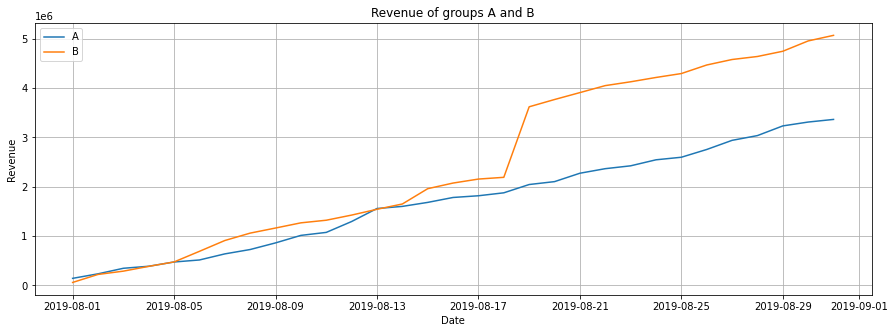

In [29]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(cumulative_A['date'], 
         cumulative_A['revenue'], 
         label='A')

plt.plot(cumulative_B['date'], 
         cumulative_B['revenue'], 
         label='B')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue of groups A and B');

**Conclusion:**

By August 8, 2019, revenue is growing almost evenly. However, between August 17 and August 21, Group B's cumulative revenue increases dramatically. This may signal spikes in the number of orders, or the appearance of very expensive orders in the sample.

#### Graph of cumulative average check by groups

Graphs of the average receipt by groups are constructed by dividing the cumulative revenue by the cumulative number of orders:

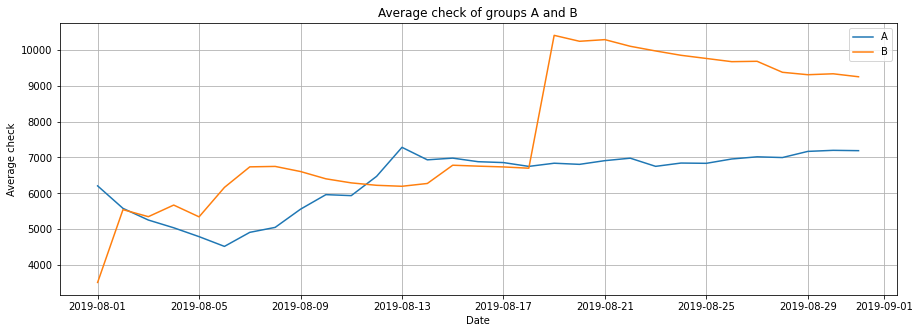

In [30]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(cumulative_A['date'], cumulative_A['revenue']/cumulative_A['orders'], label='A')
plt.plot(cumulative_B['date'], cumulative_B['revenue']/cumulative_B['orders'], label='B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average check')
plt.title('Average check of groups A and B');

**Conclusion:**

The average check has several points of contact: On August 2nd, the average check of group A sharply increased, while the average check for group B, on the contrary, decreased. On August 11-12, the average check for group B increased and 'caught up' with the average check for group A, was at its peak on August 13th, and on August 15th it again coincided in value and already held at ~7000 until the end of the analyzed period.
The average check for group B over the entire time period increased by leaps and bounds, reaching a maximum on August 19 at over 10,000. Perhaps this is due to the presence of large orders.

#### Graph of the relative change of the cumulative average check of group B to group A

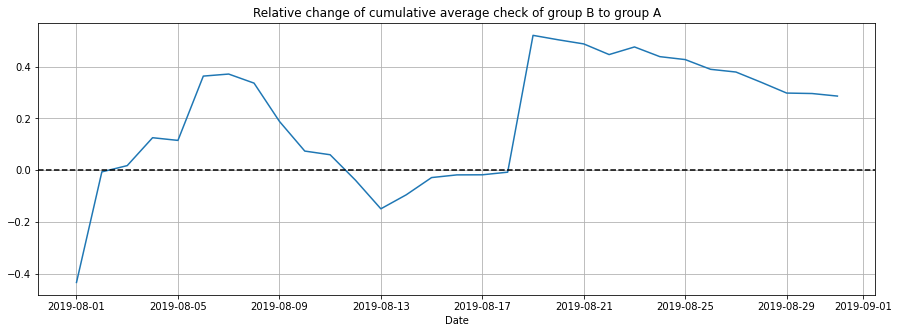

In [31]:
# a new dataframe has been created, which combines previously calculated cumulative data

cumulative_merge = cumulative_A.merge(cumulative_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# the ratio of average checks

plt.figure(figsize=(15,5))
plt.grid(True)
plt.xlabel('Date')
plt.title('Relative change of cumulative average check of group B to group A')
plt.plot(cumulative_merge['date'], (cumulative_merge['revenueB']/cumulative_merge['ordersB'])/(cumulative_merge['revenueA']/cumulative_merge['ordersA'])-1)

# added the X-axis by the axhline() method

plt.axhline(y=0, color='black', linestyle='--');

**Conclusion:**

On the chart, you can see the abrupt change in the average check: the peak on August 6-8, a sharp drop on August 13 and the maximum value for the analyzed period falling on August 19. It is necessary to further investigate the data on emissions.

Data on the minimum and maximum values of the y axis were used to plot the cumulative progression

#### Cumulative conversion graph by group

Calculation of cumulative conversion:

In [32]:
cumulative['conversion'] = cumulative['orders']/cumulative['visitors']

The data is divided into groups:

In [33]:
cumulativeDataA = cumulative[cumulative['group']=='A']

cumulativeDataB = cumulative[cumulative['group']=='B']

For plotting, the axis scale is set using the plot.axis() method.

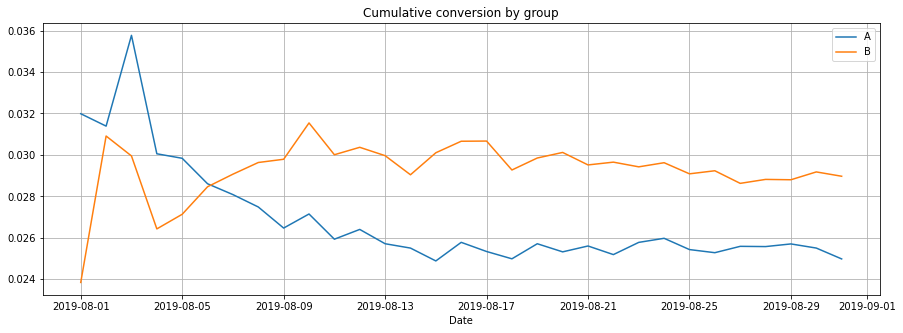

In [34]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Date')
plt.title('Cumulative conversion by group');

**Conclusion:**

In the interval between August 1 and 3, both groups experienced a sharp increase in conversion. However, after the decline on August 4, the conversion line of group B went up sharply, while the conversion line of group A almost symmetrically went down. I will analyze the data more deeply with the help of a graph of the relative difference in conversions

#### Graph of the relative change in the cumulative conversion of group B to group A

The dataframes 'cumulativeDataA'и 'cumulativeDataB' are combined so that the final dataframe 'cumulative_conversions' contains information about the date and conversion of both groups

In [35]:
cumulative_conversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                      left_on='date', 
                                                                      right_on='date', 
                                                                      how='left', 
                                                                      suffixes=['A', 'B'])

Graph of the relative difference in the cumulative conversion of group B to group A

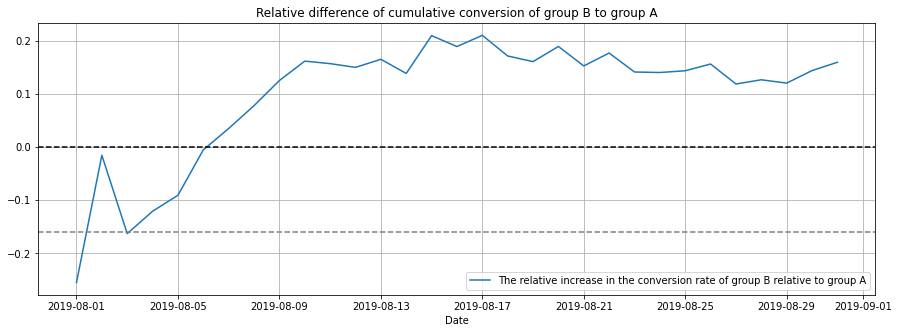

In [36]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(cumulative_conversions['date'], cumulative_conversions['conversionB']/cumulative_conversions['conversionA']-1)
plt.legend(['The relative increase in the conversion rate of group B relative to group A'])
plt.xlabel('Date')
plt.title('Relative difference of cumulative conversion of group B to group A')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.16, color='grey', linestyle='--');

**Conclusion:**

When analyzing this graph, we can conclude that the conversion of group B is significantly superior to the conversion of group A, despite the negative values at the beginning of the test

#### Dot graph of the number of orders by users

Due to the fact that users who have made many orders affect the numerator of the conversion formula, it is necessary to calculate the number of orders by users.

The new 'orders By Users' dataframe will contain unique combinations of test group values, order revenue, and dates. The information is grouped by order ID, with the number of unique order IDs. The data is also sorted by decreasing the number of orders

In [37]:
ordersByUsers = orders.drop(
    [
        'group',
        'revenue', 
        'date'
    ],
    axis=1).groupby('visitorId', 
                    as_index=False).agg(
    {
        'transactionId': pd.Series.nunique
    }
)

ordersByUsers.columns = ['visitorId', 
                         'orders']

ordersByUsers.sort_values(by='orders', 
                          ascending=False).head()

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Below is a dotted diagram of the number of orders per user. The Series 'x_values' contains values for the x-axis - the number of unique users who have made an order

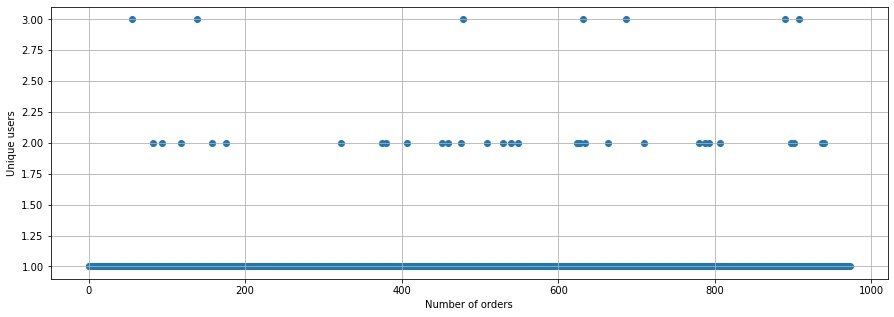

In [38]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.grid(True)
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Unique users')
plt.xlabel('Number of orders');

**Conclusion:**

The data of the dataframe 'orders By Users' showed that among the visitors of the online store there are those who make 3 orders, which is very much for the analyzed period.

The dot graph shows: there are many users who have made 2 or more orders. However, it is impossible to determine the proportion of such users on the graph.

To do this, the sample percentiles of the number of orders per user will be calculated.

#### Calculation of the 95th and 99th percentile of the number of orders per user

The percentile() method is used to calculate percentiles. The 95th and 99th percentiles of the number of orders per user are calculated:

In [39]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

**Conclusion:**

Only 1% - more than 2 orders for the analyzed period.

Users who have made more than 2 orders are considered 'abnormal'

#### Dot chart of order values

To clear the sample of outliers and abnormally expensive orders, an array of order values is analyzed using a dot graph

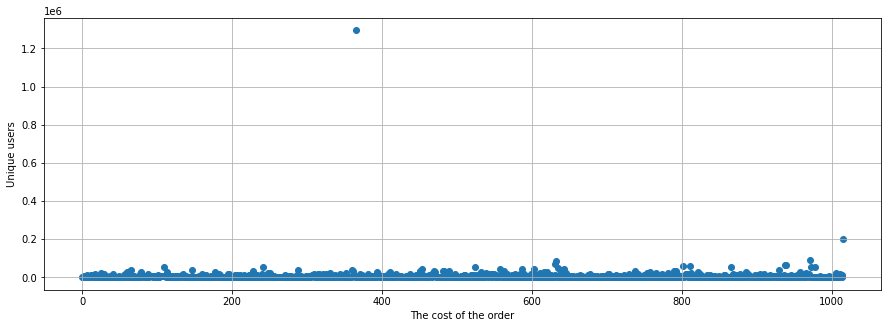

In [40]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.grid(True)
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Unique users')
plt.xlabel('The cost of the order');

**Conclusion:**

The graph shows that at least 2 orders are knocked out of the total array of values. 

The 95th and 99th percentiles are calculated to understand the boundary of abnormal orders

#### Calculation of the 95th and 99th percentile of the cost of orders

In [41]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

**Conclusion:**

No more than 5% of orders are more expensive than 26785 rubles and no more than 1% are more expensive than 53904 rubles. Accordingly, orders more than 30,000 can be taken as abnormal

#### Calculation of the statistical significance of differences in conversion between groups based on "raw" data

To begin with, it is necessary to calculate the statistical significance of differences in conversion and average receipt between groups based on 'raw' data, i.e. without removing abnormal users.

In [42]:
# in the 'visitorsADaily' dataframe, a slice is made by users
# from group A according to the data and the number of users on the specified date

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# in the 'visitorsACummulative' dataframe
# the number of users on each date in group A

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg
    (
        {
            'date': 'max',
            'visitorsPerDateA': 'sum'
        }
    ),
    axis=1)

visitorsACummulative.columns = ['date', 
                                'visitorsCummulativeA']

# in the 'visitorsBDaily' dataframe, a slice by users from the group In
# according to the data and the number of users on the specified date

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# in the 'visitorsBCummulative' dataframe, the number of
# users on each date in group B

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg
    (
        {
            'date': 'max', 
            'visitorsPerDateB': 'sum'
        }
    ),
    axis=1)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


# in 'ordersADaily', data on the number of orders and total
# revenue for group A are grouped by date

ordersADaily = (
    orders[orders['group'] == 'A']
    [
        [
            'date',
            'transactionId', 
            'visitorId', 
            'revenue'
        ]
    ].groupby('date', as_index=False).agg(
        {
            'transactionId': pd.Series.nunique, 
            'revenue': 'sum'
        }
    )
)

ordersADaily.columns = ['date', 
                        'ordersPerDateA', 
                        'revenuePerDateA']

# the 'ordersACummulative' accumulates the above data

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily
    [
        ordersADaily['date'] <= x['date']].agg
    (
        {
            'date': 'max', 
            'ordersPerDateA': 'sum', 
            'revenuePerDateA': 'sum'
        }
    ), 
    axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 
                              'ordersCummulativeA', 
                              'revenueCummulativeA']

# in 'ordersBDaily' data is grouped by date 
# about the number of orders and total revenue for the group in

ordersBDaily = (orders
                [orders['group'] == 'B']
                [
                    [
                        'date', 
                        'transactionId', 
                        'visitorId', 
                        'revenue'
                    ]
                ]
    .groupby
                (
                    'date', 
                    as_index=False
                ).agg(
                    {
                        'transactionId': pd.Series.nunique, 
                        'revenue': 'sum'
                    }
                )
               )
ordersBDaily.columns = ['date', 
                        'ordersPerDateB', 
                        'revenuePerDateB']

# in 'ordersACummulative' are also accumulated
# the above data, but already for group B

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily
    [
        ordersBDaily['date'] <= x['date']].agg
    (
        {
            'date': 'max', 
            'ordersPerDateB': 'sum', 
            'revenuePerDateB': 'sum'
        }
    ), 
    axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 
                              'ordersCummulativeB', 
                              'revenueCummulativeB']

# merged previously created dataframes

data = (ordersADaily.merge(ordersBDaily, 
                           left_on='date', 
                           right_on='date', 
                           how='left')
    .merge(ordersACummulative, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(ordersBCummulative, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitorsADaily, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitorsBDaily, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitorsACummulative, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitorsBCummulative, 
           left_on='date', 
           right_on='date', 
           how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Variables ordersByUsersA and ordersByUsersB with columns ['visitorID', 'orders'] have been created. They indicate the number of completed orders for users who have ordered at least 1 time.z

In [43]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In the variables SampleA and SampleB, the number of orders will correspond to users from different groups. Those who have not ordered anything will be matched with zeros. This is necessary in order to prepare samples for verification by the Mann-Whitney criterion.

The list of indexes is created using the np.arange() function. This will create an array of indexes in np.array format, which is required in pd.Series.

Sequences are combined by the pd.concat() function

In [44]:
pd.Series(
    0, 
    index=np.arange(
        data['visitorsPerDateA'].sum() - len(
            ordersByUsersA['orders']
        )
    ), 
    name='orders') 

0        0
1        0
2        0
3        0
4        0
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18291, dtype: int64

The SampleA variable should consist of two parts: 
- A list with the number of orders for each of the users: ordersByUsersA['orders'].
- Zeros for users who have not ordered anything. Their number is equal to the difference between the amount of visitors and the number of order records: data['visitors For Date A'].sum() - len(user orders['orders'])

In [45]:
[
    ordersByUsersA['orders'],
    pd.Series
    (
        0, 
        index=np.arange
        (
            data['visitorsPerDateA'].sum() - len(
                ordersByUsersA['orders']
            )
        ), 
        name='orders')
]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 440    1
 441    1
 442    1
 443    1
 444    1
 Name: orders, Length: 445, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18286    0
 18287    0
 18288    0
 18289    0
 18290    0
 Name: orders, Length: 18291, dtype: int64]

Thus, SampleA and SampleB will contain a selection in which each element is the number of orders of a certain user, including zero.

In [47]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

**Null hypothesis**: the conversion of groups based on "raw" data is equal to.

Next, need to apply the criterion and format the p-value, rounding it to 5 decimal places.

The relative increase in the conversion of group B: the conversion of group B / the conversion of group A is 1. I will round it up to three decimal places.

In [48]:
print
(
    "{0:.5f}".format
    (
        stats.mannwhitneyu
        (
            sampleA,
            sampleB
        )[1],
        alternative='two-sided'
    )
)

'0.01102'

In [49]:
print
(
    "{0:.2%}".format
    (
        (
            data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum()
        )/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum()
          )-1
    )
)

'15.98%'

**Conclusion:**

The P-value is slightly more than 0.05, so it is difficult to talk about rejecting the null hypothesis. Previously, we can say that there are no statistically significant differences in conversion between groups A and B.

At the same time, the relative increase in the conversion of group B to the conversion of group A = 16%

#### Calculation of the statistical significance of differences in the average order receipt between groups based on "raw" data

A null hypothesis has also been formulated and tested for this subsection: the average order receipts for groups are equal

In [50]:
# the mannwhitneyu() criterion received data on revenue from orders of groups A and B

print
(
    '{0:.3f}'.format
    (
        stats.mannwhitneyu
        (
            orders[orders['group']=='A']['revenue'],
            orders[orders['group']=='B']['revenue']
        )[1], 
        alternative='two-sided'
    )
)

'0.829'

In [51]:
# search for relative differences in the average check between groups

print
(
    '{0:.2%}'.format
    (
        orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
    )
)

'28.66%'

**Conclusion:**

P-value = 0.415, which is significantly more than 0.05. Most likely, there are statistically significant differences in the average check between the groups. This is confirmed by the relative difference of the average check between groups A and B in 29%.

In the following subsections, the search for anomalies will be carried out.

#### Calculation of the statistical significance of differences in conversion between groups based on "purified" data

The 95th and 99th percentiles of the number of orders per user found in the previous subsections are equal to 2 and 4 orders per user, respectively. At the same time, the 95th and 99th percentiles of the average checks are 28000 and 58233.2. 

So, earlier it was decided to accept as "abnormal" users those who made more than 3 orders and in the amount of more than 30000.

In [52]:
# a slice of users with more than 3 orders

usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],
     ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId']], axis=0)

# as well as a slice of users who have made orders worth more than 30,000

usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']

# the slices are combined into 'abnormalUsers'

abnormalUsers = (
    pd.concat(
        [usersWithManyOrders,usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
)

In [53]:
abnormalUsers.head()

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
Name: visitorId, dtype: int64

In [54]:
# how many abnormal users are there in total

print('Abnormal users:', abnormalUsers.shape[0])

Abnormal users: 42


Thus, 42 abnormal users were identified.

The effect of their actions on the test results was found by calculating the statistical significance of differences in conversion between the test groups based on the purified data. 

For this purpose, samples of the number of orders by users by test groups have been prepared:

In [55]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Next, the Mann-Whitney statistical criterion is applied to the obtained samples.
The null theory will say: there are no differences in conversion between groups based on "cleared" data

In [56]:
print
(
    '{0:.3f}'.format
    (
        stats.mannwhitneyu
        (
            sampleAFiltered,
            sampleBFiltered
        )[1],
        alternative='two-sided'
    )
)

'0.013'

In [57]:
print
(
    '{0:.2%}'.format
    (
        sampleBFiltered.mean()/sampleAFiltered.mean()-1
    )
)

'16.10%'

**Conclusion:**

P-value = 0.007, which most likely confirms the hypothesis of equality of conversion between groups. The relative increase in the conversion of group B to the conversion of group A is still 16%

####  Calculation of the statistical significance of differences in the average order receipt between groups based on "cleared" data

Let's test the hypothesis about the significance of differences in the average order receipt according to the "cleared" data. Null hypothesis: the average checks between the groups are equal

In [58]:
# the mannwhitneyu() criterion received the cleared revenue data from the orders of groups A and B

print('{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', 
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                                          ['revenue'], 
                                          orders[np.logical_and(orders['group'] == 'B',
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                                          ['revenue'])[1], 
                       alternative='two-sided'))




# relative differences in the average check between groups

print("{0:.2%}".format(orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                       ['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',
                                                                  np.logical_not(orders['visitorId'].isin(abnormalUsers)))]
                       ['revenue'].mean()- 1))

0.842
-3.07%


**Conclusion:**

Perhaps we can conclude that the null hypothesis was not confirmed again. P-value decreased, however, the difference between the segments changed towards a slight advantage, only 3%, of the average check of group A over the average check of group B. 

It can be concluded that anomalies can not greatly affect the results of the A/B test.

## General conclusion

- The cumulative revenue graph by group shows that the results of Group A are worse than Group B;
- Graphs of the cumulative average check also show a great advantage of the group In;
- The graph of the difference in conversion between groups reports that the results of group B are better than group A: the relative increase in the conversion of group B, relative to group A is from 10 to 20% on different dates;
- There is no statistically significant difference in conversion between the groups both according to raw data and after filtering anomalies;
- There are statistically significant differences in the average check between the groups. At the same time, the relative difference in the average check between groups A and B is 26% according to raw data. However, after clearing the data of anomalies, the statistically significant difference almost disappeared.

In this case, it is necessary to stop the test, fix the victory of group B and proceed to testing the next hypothesis.